In [1]:
# 0. 사용할 패키지 불러오기
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import os

In [2]:
# 1. 데이터셋 생성하기
# 데이터셋 불러오기
dataframe = pd.read_csv('./dataset/iris.csv')
print(dataframe.head())

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


In [3]:
# 데이터 프레임을 훈련, 검증 및 테스트로 분할하기
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

print('species', set(dataframe['species']))

96 train examples
24 validation examples
30 test examples
species {'Iris-versicolor', 'Iris-setosa', 'Iris-virginica'}


In [4]:
# 원핫 인코딩으로 바꿔준다
encoder = LabelEncoder()
encoder.fit(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

LabelEncoder()

In [5]:
print(encoder.transform(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
print(to_categorical(encoder.transform(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))

[0 1 2]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [6]:
# tf.data를 사용하여 입력 파이프라인 만들기
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = to_categorical(encoder.transform(dataframe.pop('species')))
    ds = tf.data.Dataset.from_tensor_slices((
        {
            'sepal_length_input': dataframe['sepal_length'],
            'sepal_width_input': dataframe['sepal_width'],
            'petal_length_input': dataframe['petal_length'],
            'petal_width_input': dataframe['petal_width'],
        },
        {
            'species_output':labels,
        }))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [7]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [8]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of sepal_lengths:', train_features['petal_length_input'])
print('A batch of targets:', label_batch)

Every feature: ['sepal_length_input', 'sepal_width_input', 'petal_length_input', 'petal_width_input']
A batch of sepal_lengths: tf.Tensor([1.4 5.7 5.2 5.1 1.7], shape=(5,), dtype=float64)
A batch of targets: {'species_output': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)>}


In [9]:
# 2. 모델 구성하기
sepal_length_input = tf.keras.layers.Input(shape=(1, ), dtype='float32', name='sepal_length_input')
sepal_width_input = tf.keras.layers.Input(shape=(1, ), dtype='float32', name='sepal_width_input')
petal_length_input = tf.keras.layers.Input(shape=(1, ), dtype='float32', name='petal_length_input')
petal_width_input = tf.keras.layers.Input(shape=(1, ), dtype='float32', name='petal_width_input')

concatenated = tf.keras.layers.Concatenate(axis=-1, name='concatenated')([sepal_length_input, sepal_width_input, petal_length_input, petal_width_input])

dense = tf.keras.layers.Dense(units=8, activation='relu', name='iris_dense')(concatenated)
output = tf.keras.layers.Dense(units=len(encoder.classes_), activation='softmax', name='species_output')(dense)

In [10]:
model = tf.keras.models.Model(
    inputs={
        'sepal_length_input': sepal_length_input,
        'sepal_width_input': sepal_width_input,
        'petal_length_input': petal_length_input,
        'petal_width_input': petal_width_input
    },
    outputs={'species_output': output},
    name='iris_classification_model'
)
model.summary()

Model: "iris_classification_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sepal_length_input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
sepal_width_input (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
petal_length_input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
petal_width_input (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________

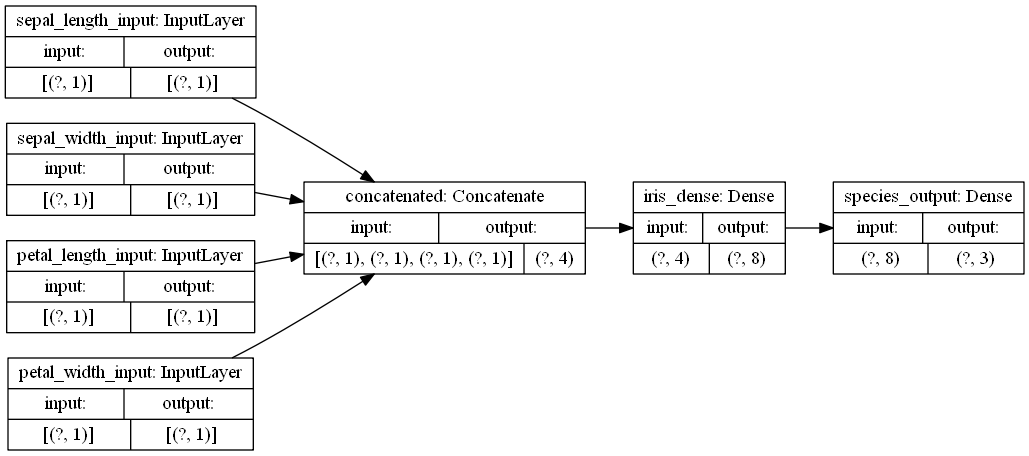

In [11]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [12]:
# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model_dir = './model/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_filepath = model_dir + 'iris.h5'
checkpointer = ModelCheckpoint(filepath=model_filepath, monitor='val_loss', verbose=1, save_best_only=True)

# 학습의 자동중단! 3번동안 나아지지 않으면 stop!
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [14]:
# 4. 모델 학습시키기
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=10, callbacks=[checkpointer, early_stop])
history = model.fit(train_ds, epochs=32, validation_data=val_ds, callbacks=[checkpointer, early_stop])

Epoch 1/32
 1/20 [>.............................] - ETA: 0s - loss: 5.1263 - accuracy: 0.2000
Epoch 00001: val_loss improved from inf to 1.65878, saving model to ./model\iris.h5
20/20 [==============================] - 0s 20ms/step - loss: 2.9003 - accuracy: 0.4271 - val_loss: 1.6588 - val_accuracy: 0.7500
Epoch 2/32
 1/20 [>.............................] - ETA: 0s - loss: 2.7019 - accuracy: 0.6000
Epoch 00002: val_loss improved from 1.65878 to 1.34659, saving model to ./model\iris.h5
20/20 [==============================] - 0s 5ms/step - loss: 2.3611 - accuracy: 0.6146 - val_loss: 1.3466 - val_accuracy: 0.7917
Epoch 3/32
 1/20 [>.............................] - ETA: 0s - loss: 3.2793 - accuracy: 0.4000
Epoch 00003: val_loss improved from 1.34659 to 1.10257, saving model to ./model\iris.h5
20/20 [==============================] - 0s 5ms/step - loss: 1.9799 - accuracy: 0.6146 - val_loss: 1.1026 - val_accuracy: 0.7917
Epoch 4/32
 1/20 [>.............................] - ETA: 0s - loss: 0.

 1/20 [>.............................] - ETA: 0s - loss: 0.3524 - accuracy: 1.0000
Epoch 00028: val_loss did not improve from 0.38836
20/20 [==============================] - 0s 3ms/step - loss: 0.3689 - accuracy: 0.9688 - val_loss: 0.4042 - val_accuracy: 0.8750


In [15]:
# 6. 모델 평가하기
print("정확도 : %.2f " %(model.evaluate(test_ds)[1]))

6/6 [==============================] - 0s 1ms/step - loss: 0.3590 - accuracy: 0.9667
정확도 : 0.97 


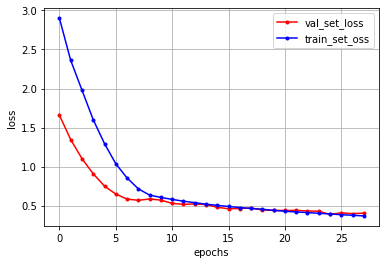

In [16]:
# 5. 학습과정 살펴보기
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [17]:
model.predict(test_ds.take(1))

{'species_output': array([[0.7980987 , 0.18881296, 0.01308829],
        [0.03580205, 0.6901463 , 0.27405158],
        [0.8315946 , 0.15806124, 0.01034426],
        [0.78839797, 0.19758123, 0.01402074],
        [0.02681114, 0.454842  , 0.5183469 ]], dtype=float32)}

잘 학습되는 것을 볼 수 있다.